# Índice

1. [Preparacion del Dataset](#preparaciondataset)

    1.1 [Visualización de los datos](#visualizaciondatos) <br>
    1.2 [Carga del Dataset](#cargadeldataset) <br>
    1.3 [Modificación de imagenes a baja y media resolución](#modimgs) <br>
    1.4 [Creación de los datasets](#creaciondatasets)
    
    - [a). Baja resolución (kxk)](#br) <br>
    - [b). Media resolución (mxm)](#mr)<br>
    - [c). Alta resolución (nxn)](#hr)
2. [Creación y Entrenamiento de modelos](#creacionentrenamientomodelos)

    2.1 [Autoencoder (Vanilla)](#ae) <br>
    2.2 [Variational Auto Encoder (VAE)](#vae) <br>
    2.3 [GAN (Sin U-Net)](#gan) <br>
    2.4 [GAN (U-Net o cGAN o pix2pix)](#cgan) <br>
    2.5 [SRGAN(?)](#srgan) <br>
    2.6 [ESRGAN(?)](#esrgan) <br>
3. [Comparación de modelos](#comparacionmodelos)

    3.1 [Métricas individuales](#mi) <br>
    3.2 [Tablas comparativas de métricas](#tcm) <br>
    3.3 [Comparativa de imágenes](#ci)

Imports:

In [5]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import cv2
import math
import time
from IPython import display
import pandas as pd

# 1. Preparación del Dataset <a id="preparaciondataset"></a>

## 1.1 Visualización de los datos <a id="visualizaciondatos"></a>

Vamos a abrir un par de imágenes para ver el contenido del dataset.

In [6]:
show_image = Image.open("./Dataset/DIV2K_train_HR/0001.png")
show_image.size

(2040, 1404)

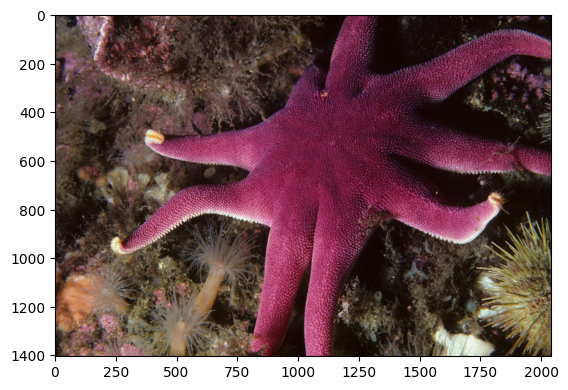

In [7]:
plt.imshow(show_image)

In [8]:
show_image = Image.open("./Dataset/DIV2K_train_HR/0124.png")
show_image.size

(1356, 2040)

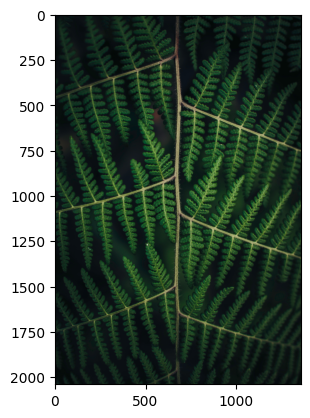

In [9]:
plt.imshow(show_image)

Como se puede observar, las imágenes tienen un tamaño constante de 2040 de ancho o de alto.

## 1.2 Funciones útiles:

Esta función enseña las diferencias entre la imagen de input, la imagen real y la predicha:

In [50]:
def plot_model_diff(model,valid_dataset):

    input, target = next(iter(valid_dataset))

    input = input.numpy()
    target = target.numpy()

    plt.figure(figsize=(15, 15))

    plt.subplot(1, 3, 1)
    plt.imshow(input[0]) 
    plt.title('Input')

    plt.subplot(1, 3, 2)
    plt.imshow(target[0])  
    plt.title('Ground Truth')
    
    plt.subplot(1, 3, 3)
    plt.imshow(model.predict(input,verbose=0)[0]) 
    plt.title('Prediction')

    plt.show()

Esta funcion muestra un ejemplo del dataset:

In [11]:
def plot_diff(valid_dataset):
    input, target = next(iter(valid_dataset))
    input = input.numpy()
    target = target.numpy()
    
    plt.figure(figsize=(15, 15))

    plt.subplot(1, 3, 1)
    plt.imshow(input[0]) 
    plt.title('Input')

    plt.subplot(1, 3, 2)
    plt.imshow(target[0])  
    plt.title('Ground Truth')

    plt.show()

## 1.2 Carga del Dataset <a id="cargadeldataset"></a>

Se definen algunas variables globales como las rutas de los directorios del dataset

In [12]:
DIV2K_TRAIN_HR_PATH = "Dataset/DIV2K_train_HR/*.png"
DIV2K_VALID_HR_PATH = "Dataset/DIV2K_valid_HR/*.png"

En este caso se está haciendo uso del dataset DIV2k (Explicar un poco mas sobre este dataset)

Se define el número de batch

In [13]:
BATCH_SIZE = 1

## 1.3 Modificación de imagenes a baja y media resolución <a id="modimgs"></a>

Esta función la he encontrado aquí: https://gist.github.com/blzq/c87d42f45a8c5a53f5b393e27b1f5319 . Añade desenfoque gausiano dependiendo del tamaño del kernel y del valor sigma:

In [14]:
def gaussian_blur(img, kernel_size=2, sigma=50):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    img = tf.expand_dims(img, axis=0)  
    img_blurred = tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                          padding='SAME', data_format='NHWC')
    img_blurred = tf.squeeze(img_blurred, axis=0)  

    return img_blurred

Añado una máscara y defino la cantidad de ruido y lo grande que es la máscara

In [15]:
def corrupt_part_of_image(image, noise_level, corruption_level=0.04):
    
    mask = tf.random.uniform(tf.shape(image)[:2]) < corruption_level
    noise = tf.random.normal(tf.shape(image), stddev=noise_level)
    noise = (noise + 1.0) / 2.0
    corrupted_image = tf.where(mask[..., tf.newaxis], tf.clip_by_value(image + noise, 0.0, 1.0), image)
    
    return corrupted_image

Función que añade pasándole unos parámetros: ruido y desenfoque

In [16]:
def random_jitter(img,noise=0.1,corrupt=0.04,blur=2):
    img = gaussian_blur(img,kernel_size=blur)
    img = corrupt_part_of_image(img,noise_level=noise,corruption_level=corrupt)
    return img

Función para cargar una imagen png y la transforma a float32

In [17]:
def load(input_path):
    img = tf.io.read_file(input_path)
    img = tf.cast(tf.image.decode_png(img,channels=3),tf.float32)
    return img

Función para normalizar la imagen

In [18]:
def normalize(img):
    #img = (img / 127.5) - 1 # Normalización de la imagen entre [-1 y 1]
    img = img / 255 #Normalización de la imagen entre [0 y 1]
    return img

Funciones para crear una canalización de datos y procesar las imágenes de alta resolución:

In [19]:
#Target = Ground Truth ; Input = Imagen que se va a meter al modelo

# Salida: 256 y 1024
def low_res_img_map(input_path):
    target_img = load(input_path)
    target_img = tf.image.resize(target_img,size=(1024,1024))
    
    input_image = tf.image.resize(target_img,size=(256,256))

    input_image = random_jitter(input_image)

    target_img = normalize(target_img)
    input_image = normalize(input_image)

    return input_image, target_img

# Salida: 512 y 1024
def med_res_img_map(input_path):
    target_img = load(input_path)
    target_img = tf.image.resize(target_img,size=(1024,1024))
    
    input_image = tf.image.resize(target_img,size=(512,512))

    input_image = random_jitter(input_image,corrupt=0.1)

    target_img = normalize(target_img)
    input_image = normalize(input_image)

    return input_image, target_img

# Saalda: 1024 y 1024
def high_res_img_map(input_path):
    target_img = load(input_path)
    target_img = tf.image.resize(target_img,size=(1024,1024))

    input_image = random_jitter(target_img,noise=0.4,corrupt=0.2,blur=8)

    target_img = normalize(target_img)
    input_image = normalize(input_image)

    return input_image, target_img

## 1.4 Creación de los datasets <a id="creaciondatasets"></a>

Se va ha crear una canalización de los datos para que las imágenes se procesen en la cpu en tiempo de entrenamiento y no en GPU:

In [20]:
def create_dataset(dataset_path, res_func):
    dataset = tf.data.Dataset.list_files(str(dataset_path))
    dataset = dataset.map(res_func, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

### a). Baja resolución (256x256) <a id="br"></a>

In [21]:
low_res_train_dataset = create_dataset(DIV2K_TRAIN_HR_PATH,low_res_img_map)
low_res_valid_dataset = create_dataset(DIV2K_VALID_HR_PATH,low_res_img_map)

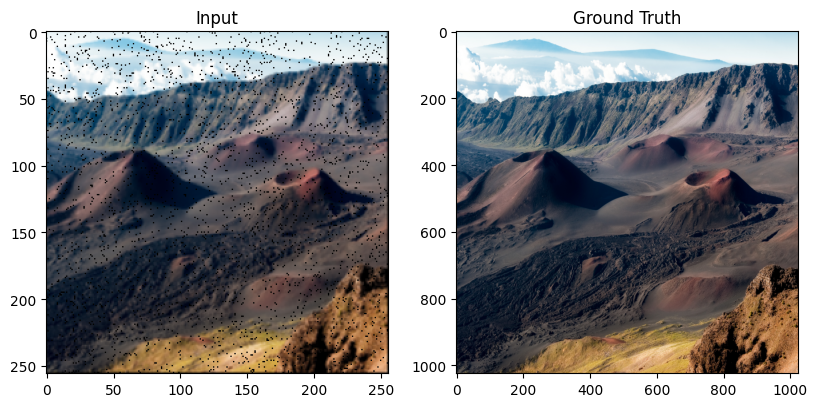

In [22]:
plot_diff(low_res_train_dataset)

### b). Media resolución (512x512) <a id="mr"></a>

In [23]:
med_res_train_dataset = create_dataset(DIV2K_TRAIN_HR_PATH,med_res_img_map)
med_res_valid_dataset = create_dataset(DIV2K_VALID_HR_PATH,med_res_img_map)

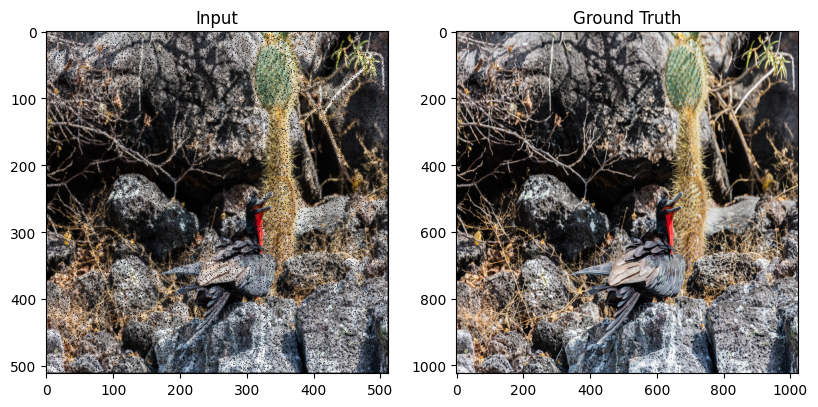

In [24]:
plot_diff(med_res_train_dataset)

### c). Alta resolución (1024x1024) <a id="hr"></a>

In [25]:
high_res_train_dataset = create_dataset(DIV2K_TRAIN_HR_PATH,high_res_img_map)
high_res_valid_dataset = create_dataset(DIV2K_VALID_HR_PATH,high_res_img_map)

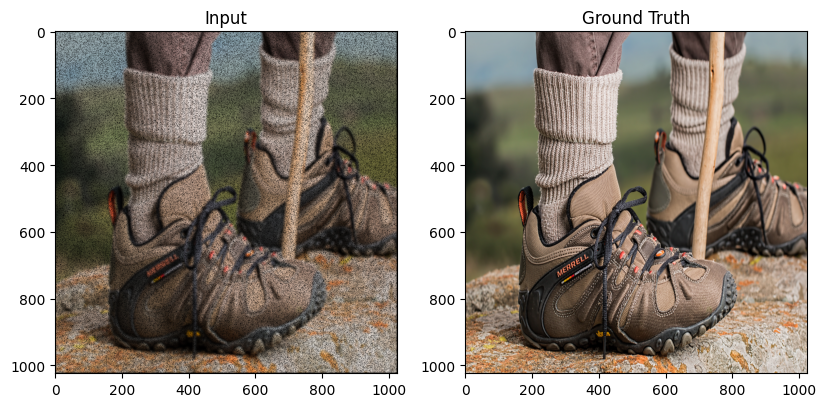

In [26]:
plot_diff(high_res_train_dataset)

In [27]:
a = = 0

SyntaxError: invalid syntax (654965441.py, line 1)

# 2. Creación y Entrenamiento de modelos <a id="creacionentrenamientomodelos"></a>

Se comprueba que se detecta la tarjeta gráfica:

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2.1 Autoencoder (Vanilla) <a id="ae"></a>

Un autoencoder es un tipo de red de neuronas capaz de aprender características de los datos, reducir su dimensionalidad y reconstruir estos mismos manteniendo parte de su fidelidad. Es decir, consta de tres partes: *codificador*, *espacio latente* y *decodificador*.

El *codificador* o en ingles *encoder* se puede representar de la siguiente forma:

$h_i = g(X_i)$ , donde $h_i ∈ R^q$ que simboliza el *espacio latente*;

El *decodificador* o en ingles *decoder* se puede representar de la siguiente forma:

$\tilde{x}_i = f(h_i) = f(g(x_i))$ , donde $\tilde{x}_i ∈ R^n$ ;

Para el entrenamiento del autoencoder, hay que buscar las funciones f y g que minimicen la diferencia entre $x_i$ y $\tilde{x}_i$:

$argmin_{f,g} <[∆(x_i,f(g(x_i)))]>$ ;

$<·>$, Indica media de todas las desviaciones observadas.

![Auto Encoder Vanilla](./Images/latent_representation_AE.png)

### 2.1.1 Creación del Modelo

Se va a crear una clase autoencoder un tanto diferente, para este autoencoder se van ha utilizar entradas de datos diferentes a la salida. Se va ha intentar reescalar las imágenes de 256x256 y 512x512 a 1024x1024, añadiendo 2 y 1 capas más de convolución respectivamente:

In [ ]:
class Autoencoder(tf.keras.models.Model):
    def __init__(self,input_shape):
        super().__init__()
        
        #Codificador
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=input_shape),
            tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
        ])

        #Decodificador
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
        ])

        #Si la imagen tiene un tamaño de 1024 la salida son 3 filtros (RGB)
        if input_shape[0] == 1024:
            self.decoder.add(tf.keras.layers.Convolution2D(3, (3, 3), activation='sigmoid', padding='same'))
        
        #Si la imagen tiene un tamaño de 512 la salida es una capa convolucional mas 3 filtros (RGB)
        if input_shape[0] == 512:
            self.decoder.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', padding='same'))
            self.decoder.add(tf.keras.layers.UpSampling2D((2, 2)))
            self.decoder.add(tf.keras.layers.Convolution2D(3, (3, 3), activation='sigmoid', padding='same'))

        #Si la imagen tiene un tamaño de 256 la salida son dos capas convolucionales mas 3 filtros (RGB)
        if input_shape[0] == 256:
            self.decoder.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', padding='same'))
            self.decoder.add(tf.keras.layers.UpSampling2D((2, 2)))
            self.decoder.add(tf.keras.layers.Convolution2D(32, (3, 3), activation='relu', padding='same'))
            self.decoder.add(tf.keras.layers.UpSampling2D((2, 2)))
            self.decoder.add(tf.keras.layers.Convolution2D(3, (3, 3), activation='sigmoid', padding='same'))


    def call(self, x):
        return self.decoder(self.encoder(x))

### 2.1.2 Entrenamiento del modelo

Se declaran los tres modelos: 256,512 y 1024:

In [ ]:
autoencoder_256 = Autoencoder(input_shape=(256,256,3))
autoencoder_512 = Autoencoder(input_shape=(512,512,3))
autoencoder_1024 = Autoencoder(input_shape=(1024,1024,3))

Se entrena cada red con pérdida MSE y con el optimizador ADAM:

In [ ]:
autoencoder_1024.compile(loss='mean_squared_error', optimizer='adam')
history_high_res = autoencoder_1024.fit(high_res_train_dataset, epochs=25)

Epoch 1/25


800/800 [==============================] - 239s 221ms/step - loss: 0.0206
Epoch 2/25
800/800 [==============================] - 177s 221ms/step - loss: 0.0099
Epoch 3/25
800/800 [==============================] - 177s 220ms/step - loss: 0.0090
Epoch 4/25
800/800 [==============================] - 178s 221ms/step - loss: 0.0077
Epoch 5/25
800/800 [==============================] - 179s 222ms/step - loss: 0.0078
Epoch 6/25
800/800 [==============================] - 175s 218ms/step - loss: 0.0074
Epoch 7/25
800/800 [==============================] - 176s 219ms/step - loss: 0.0069
Epoch 8/25
800/800 [==============================] - 180s 224ms/step - loss: 0.0072
Epoch 9/25
800/800 [==============================] - 176s 219ms/step - loss: 0.0069
Epoch 10/25
800/800 [==============================] - 178s 222ms/step - loss: 0.0066
Epoch 11/25
800/800 [==============================] - 176s 218ms/step - loss: 0.0067
Epoch 12/25
800/800 [==============================] - 175s 218ms/step - l

Se mira la pérdida del modelo:

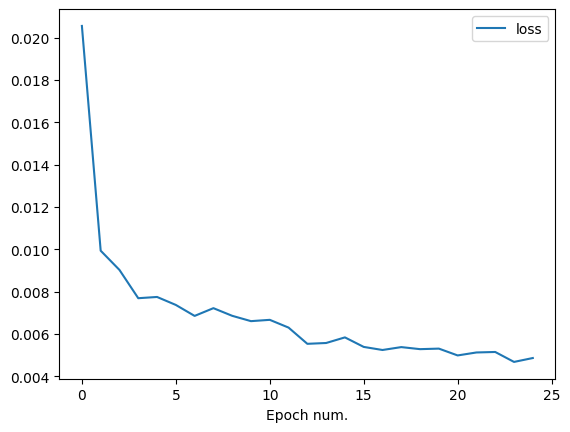

In [ ]:
pd.DataFrame(history_high_res.history).plot()
plt.xlabel('Epoch num.')
plt.show()

In [ ]:
autoencoder_512.compile(loss='mean_squared_error', optimizer='adam')
history_mid_res = autoencoder_512.fit(med_res_train_dataset, epochs=30)

Epoch 1/30


800/800 [==============================] - 103s 109ms/step - loss: 0.0232
Epoch 2/30
800/800 [==============================] - 84s 105ms/step - loss: 0.0157
Epoch 3/30
800/800 [==============================] - 86s 107ms/step - loss: 0.0111
Epoch 4/30
800/800 [==============================] - 85s 106ms/step - loss: 0.0102
Epoch 5/30
800/800 [==============================] - 84s 104ms/step - loss: 0.0102
Epoch 6/30
800/800 [==============================] - 84s 105ms/step - loss: 0.0092
Epoch 7/30
800/800 [==============================] - 84s 105ms/step - loss: 0.0091
Epoch 8/30
800/800 [==============================] - 82s 102ms/step - loss: 0.0087
Epoch 9/30
800/800 [==============================] - 81s 102ms/step - loss: 0.0085
Epoch 10/30
800/800 [==============================] - 79s 99ms/step - loss: 0.0083
Epoch 11/30
800/800 [==============================] - 79s 99ms/step - loss: 0.0081
Epoch 12/30
800/800 [==============================] - 79s 99ms/step - loss: 0.0082
Ep

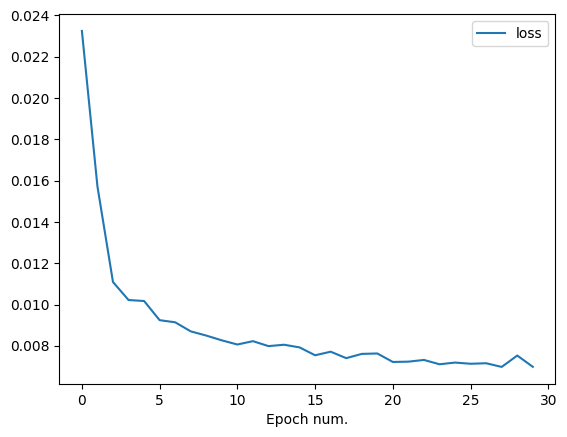

In [ ]:
pd.DataFrame(history_mid_res.history).plot()
plt.xlabel('Epoch num.')
plt.show()

In [ ]:
autoencoder_256.compile(loss='mean_squared_error', optimizer='adam')
history_low_res = autoencoder_256.fit(low_res_train_dataset, epochs=40)

Epoch 1/40


800/800 [==============================] - 39s 43ms/step - loss: 0.0288
Epoch 2/40
800/800 [==============================] - 36s 44ms/step - loss: 0.0214
Epoch 3/40
800/800 [==============================] - 33s 42ms/step - loss: 0.0164
Epoch 4/40
800/800 [==============================] - 34s 42ms/step - loss: 0.0165
Epoch 5/40
800/800 [==============================] - 35s 43ms/step - loss: 0.0142
Epoch 6/40
800/800 [==============================] - 34s 43ms/step - loss: 0.0136
Epoch 7/40
800/800 [==============================] - 37s 46ms/step - loss: 0.0131
Epoch 8/40
800/800 [==============================] - 35s 44ms/step - loss: 0.0129
Epoch 9/40
800/800 [==============================] - 35s 44ms/step - loss: 0.0127
Epoch 10/40
800/800 [==============================] - 35s 44ms/step - loss: 0.0124
Epoch 11/40
800/800 [==============================] - 35s 44ms/step - loss: 0.0123
Epoch 12/40
800/800 [==============================] - 35s 44ms/step - loss: 0.0119
Epoch 13/40


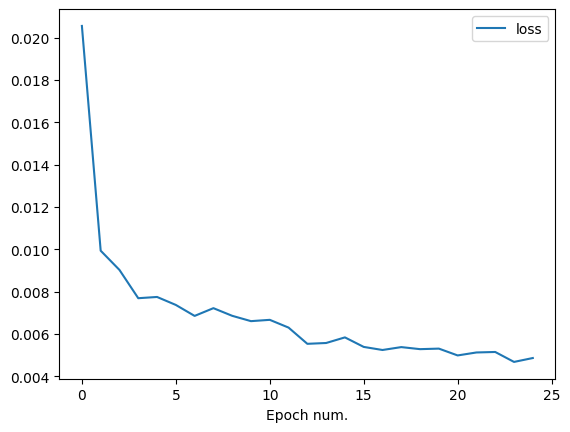

In [ ]:
pd.DataFrame(history_high_res.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Guardamos los modelos:

In [ ]:
autoencoder_256.save("Checkpoints/Autoencoder/autoencoder_256_model")
autoencoder_512.save("Checkpoints/Autoencoder/autoencoder_512_model")
autoencoder_1024.save("Checkpoints/Autoencoder/autoencoder_1024_model")

INFO:tensorflow:Assets written to: Checkpoints/Autoencoder/autoencoder_256_model\assets


INFO:tensorflow:Assets written to: Checkpoints/Autoencoder/autoencoder_256_model\assets


INFO:tensorflow:Assets written to: Checkpoints/Autoencoder/autoencoder_512_model\assets


INFO:tensorflow:Assets written to: Checkpoints/Autoencoder/autoencoder_512_model\assets


INFO:tensorflow:Assets written to: Checkpoints/Autoencoder/autoencoder_1024_model\assets


INFO:tensorflow:Assets written to: Checkpoints/Autoencoder/autoencoder_1024_model\assets


### 2.1.3 Resultados del entrenamiento:

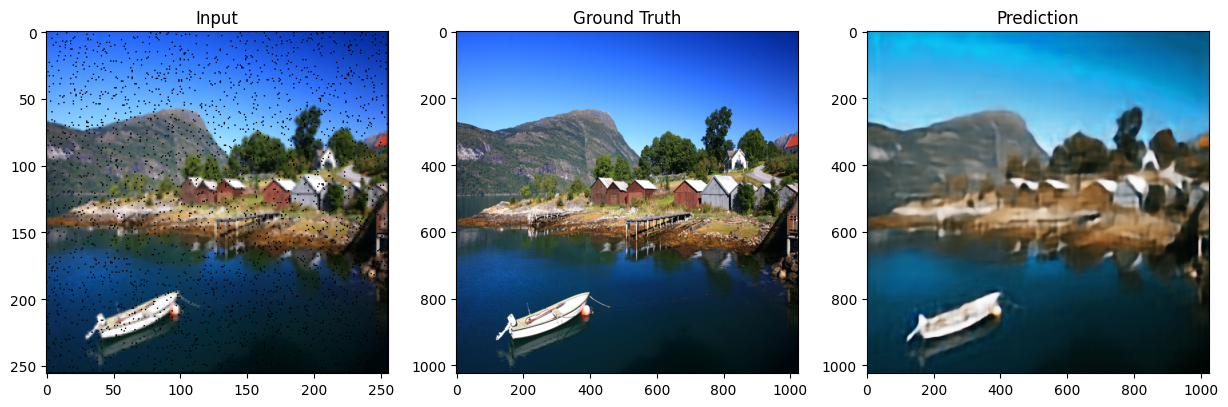

In [ ]:
plot_model_diff(autoencoder_256,low_res_valid_dataset)

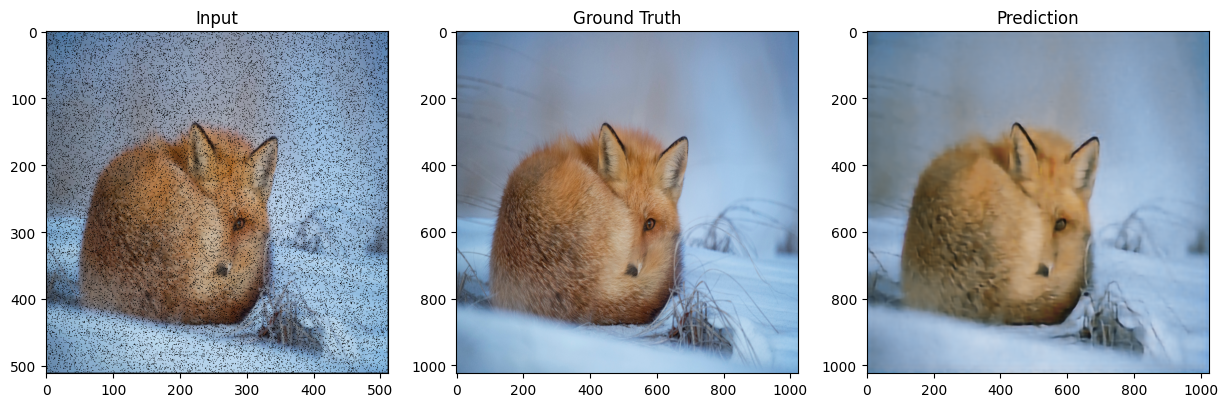

In [ ]:
plot_model_diff(autoencoder_512,med_res_valid_dataset)

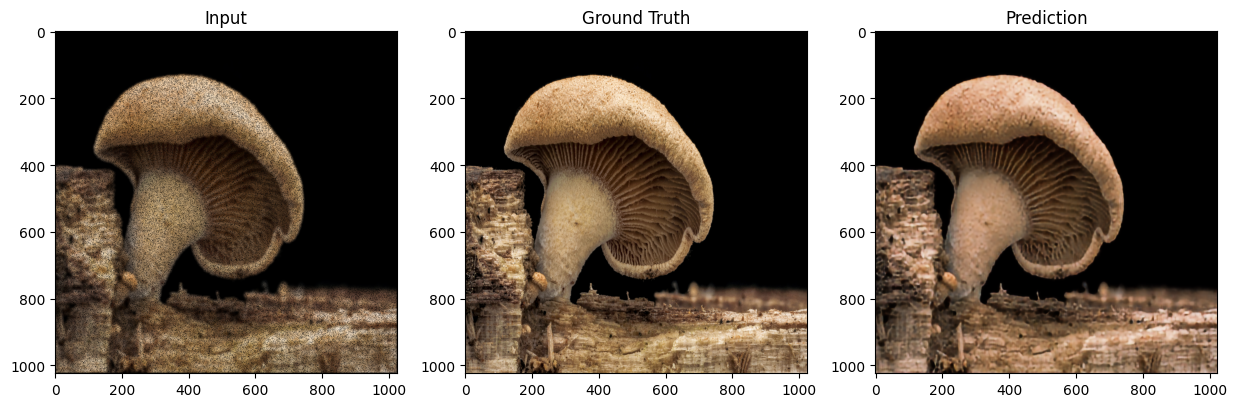

In [ ]:
plot_model_diff(autoencoder_1024,high_res_valid_dataset)

Como podemos observar los resultados no son para nada malos, pero pueden mejorarse:

## 2.2 Variational Auto Encoder (VAE) <a id="vae"></a>

Teniendo nuestro autoencoder ya creado, lo que se busca con un variational autoencoder es, con la misma estructura, intentar regularizar mejor los datos como se ve en el gráfico: <br><br>
![vae](./Images/variational_autoencoder.png)

Vamos a crear un propio dataset con una sola x:

In [42]:
def vae_map(input_path):

    target_img = load(input_path)
    target_img = tf.image.resize(target_img,size=(1024,1024))
    target_img = normalize(target_img)

    return target_img

In [53]:
vae_dataset = create_dataset(DIV2K_TRAIN_HR_PATH,vae_map)
vae_valid_dataset = create_dataset(DIV2K_VALID_HR_PATH,vae_map)

In [44]:
class CVAE(tf.keras.Model):

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim

    self.encoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1024,1024,3)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same'), # 512
        tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), activation='relu', padding='same'), # 256
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2, 2), activation='relu', padding='same'), # 128
        tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2, 2), activation='relu', padding='same'), # 64
        tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2, 2), activation='relu', padding='same'), # 32
        tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2, 2), activation='relu', padding='same'), # 16
        tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2, 2), activation='relu', padding='same'), # 8
        tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=(2, 2), activation='relu', padding='same'), # 4
        tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=(2, 2), activation='relu', padding='same'), # 2

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(latent_dim+latent_dim),
    ])
    
    self.decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
        tf.keras.layers.Dense(units=2*2*1024, activation='relu'),
        tf.keras.layers.Reshape(target_shape=(2, 2, 1024)),
        tf.keras.layers.Conv2DTranspose(filters=1024, kernel_size=3, strides=2, padding='same', activation='relu'), # 4
        tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', activation='relu'), # 4
        tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', activation='relu'), # 8
        tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', activation='relu'), # 16
        tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', activation='relu'), # 32
        tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', activation='relu'), # 64
        tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu'), # 128
        tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu'), # 256
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'), # 512
        tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same'),
    ])
  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


In [45]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss

In [46]:
def fit(model,train_dataset,epochs):

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        print("Epoch", epoch)
        batch_count = 0  # Inicializa el conteo de lotes
        for train_x in train_dataset:
            train_step(model, train_x, optimizer)
            with tf.device('/CPU:0'):
                batch_count += 1
                if batch_count % 100 == 0:  # Imprime un punto cada 100 lotes
                    print(".", end="", flush=True)        
            end_time = time.time()
        with tf.device('/CPU:0'):
            time_taken = end_time - start_time
            print("\nTime taken for epoch {}: {:.2f} seconds".format(epoch, time_taken))



In [47]:
LATENT_DIM = 2048
epochs = 80
cvae = CVAE(LATENT_DIM)

In [ ]:
fit(cvae,vae_dataset,epochs)

In [62]:
def plot_model_diff_vae(model,valid_dataset):

    input  = next(iter(valid_dataset))

    input = input.numpy()

    plt.figure(figsize=(15, 15))

    plt.subplot(1, 2, 1)
    plt.imshow(input[0]) 
    plt.title('Input')

    plt.subplot(1, 2, 2)

    mean, logvar = model.encode(input)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)


    plt.imshow(x_logit[0]) 
    plt.title('Prediction')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


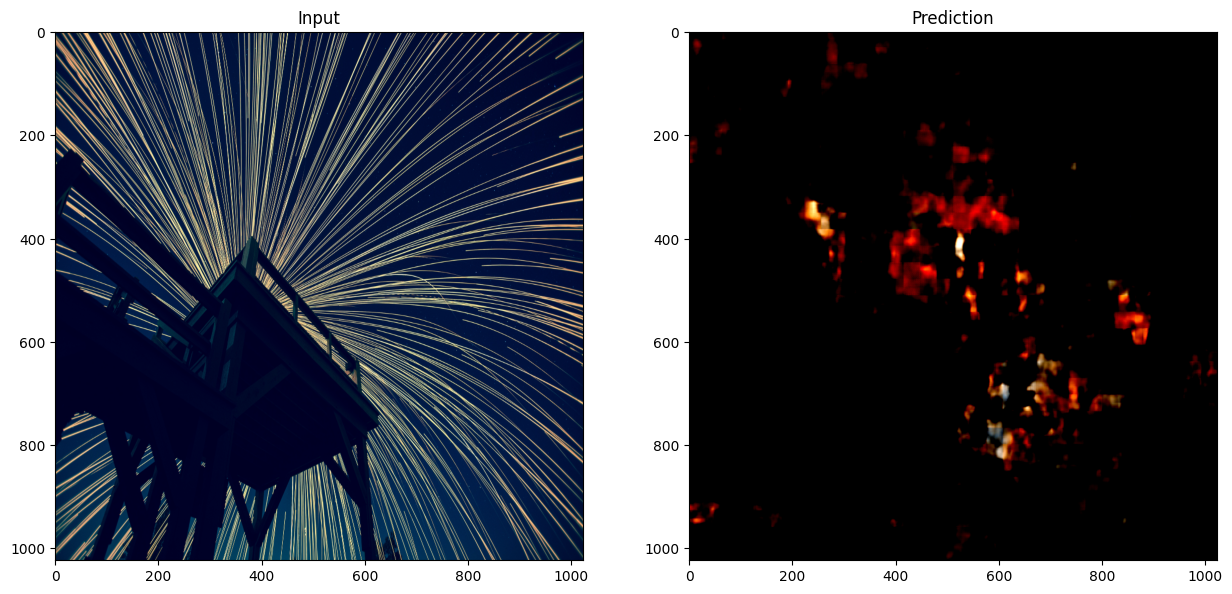

In [72]:
plot_model_diff_vae(cvae,vae_valid_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


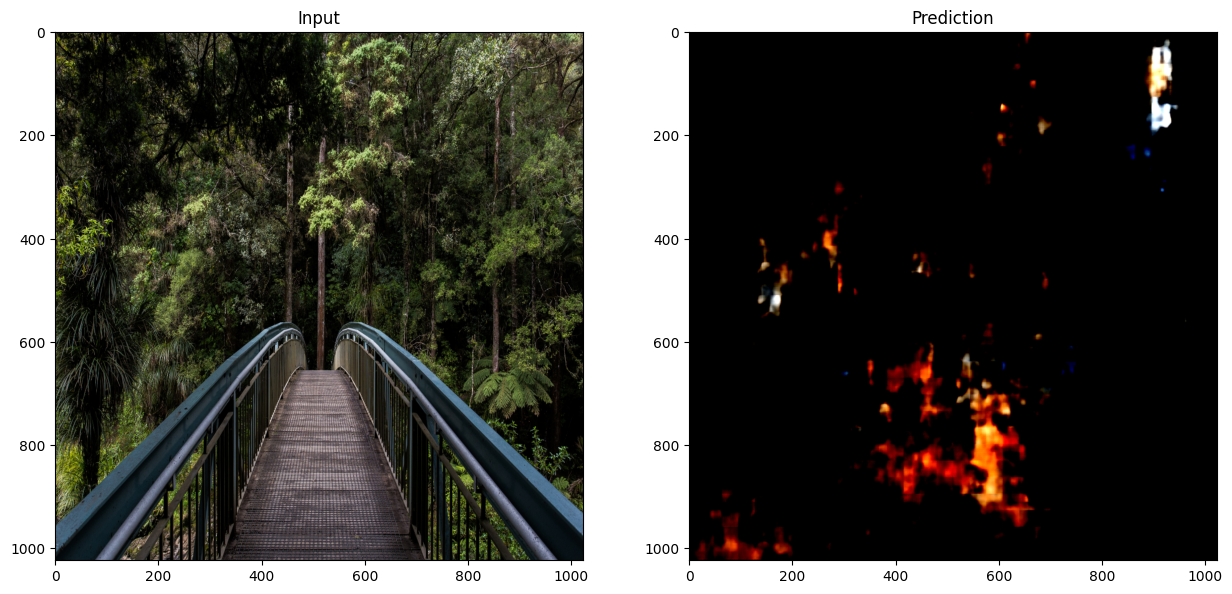

In [75]:
plot_model_diff_vae(cvae,vae_valid_dataset)

La red es lo suficientemente compleja coma para no poder entrenar de forma correcta.

## 2.3 GAN (Sin U-Net) <a id="gan"></a>

Las redes GAN *(Generative Adversarial Networks)* son un tipo de arquitectura de red de neuronas. Este tipo de arquitectura consta de dos partes: la primera parte es el generador que se encarga de generar imágenes y la segunda es el discriminador que se encarga de diferenciar si las imágenes son reales o no. Estas dos redes compiten por obtener los mejores resultados. El concepto de estas redes es parecido al algoritmo minimax, el discriminador y el generador intentan minimizar su valor de pérdida y maximizar la de su oponente.

![Basic Gan](./Images/Basic_GAN.png)

La fórmula general de las redes GAN parte de la fórmula de la entropía cruzada:<br><br>
$L = E \space y*ln(\widehat{y}) + (1-y)*ln(1-\widehat{y})$

Si $y = 1 ; \space \widehat{y} = D(x) => L = ln[D(x)]$<br>

Si $y = 0 ; \space \widehat{y} = D(G(z)) => L = ln[1 - D(G(z))]$ <br>

Entonces: $L = ln[D(x)] + ln[1 - D(G(z))]$

$E(L) = E(ln[D(x)]) + E(ln[1-D(G(z))])$

así que: $V(G,D) = E_{x-PData}[ln(D(x))] + E_{Pz}[ln(1-D(G(z)))]$

Se declaran las funciones de downsample y upsample que se utilizarán mas adelante:

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


### 2.3.1 Generadores

In [ ]:
def Generator_256():

  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  #Downsample
  x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs) #128
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x) # 64
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(x) # 32
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')(x) # 16
  x = tf.keras.layers.BatchNormalization()(x)

  #Upsample
  x = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x) # 32
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(x) # 64
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu')(x) # 128
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu')(x) # 256
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu')(x) # 512
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(x) # 1024

  return tf.keras.Model(inputs=inputs, outputs=x)

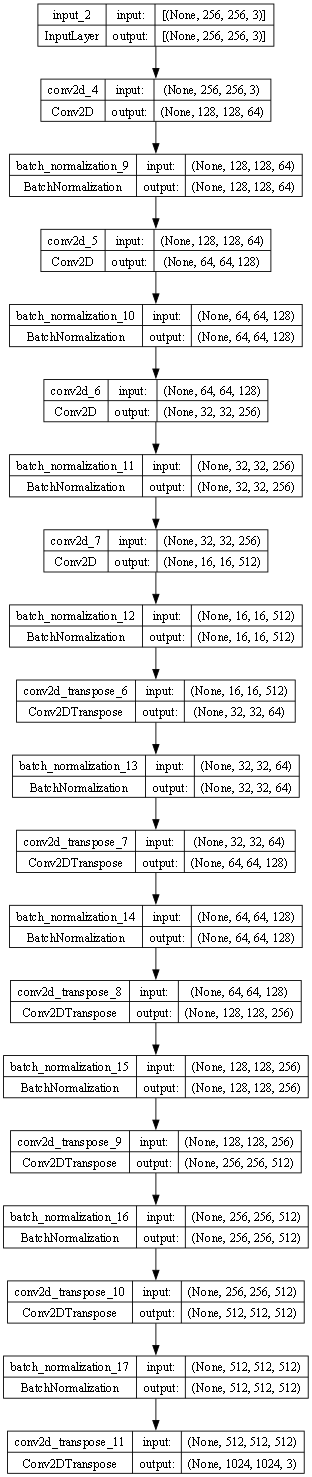

In [ ]:
generator_256 = Generator_256()
tf.keras.utils.plot_model(generator_256, show_shapes=True, dpi=64)

In [ ]:
def Generator_512():

  inputs = tf.keras.layers.Input(shape=[512, 512, 3])

  #Downsample
  x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs) #256
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x) # 128
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(x) # 64
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')(x) # 32
  x = tf.keras.layers.BatchNormalization()(x)

  #Upsample
  x = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x) # 64
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(x) # 128
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu')(x) # 256
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu')(x) # 512
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(x) # 1024


  return tf.keras.Model(inputs=inputs, outputs=x)

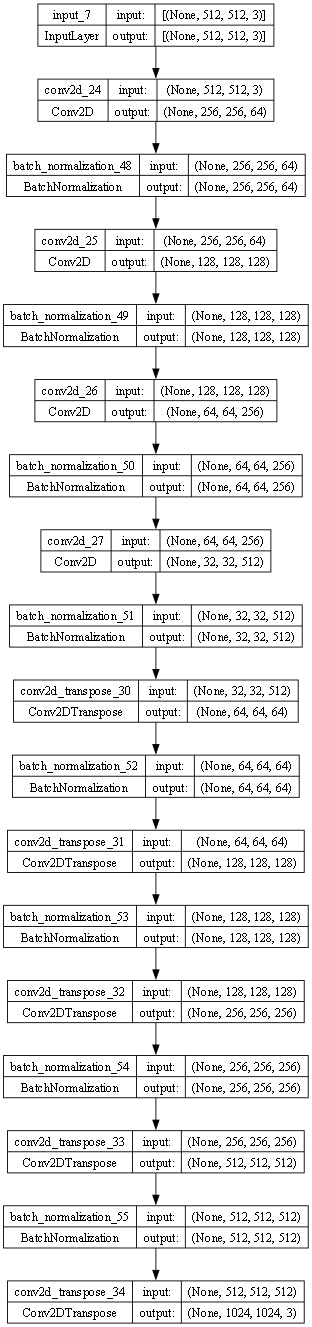

In [ ]:
generator_512 = Generator_512()
tf.keras.utils.plot_model(generator_512, show_shapes=True, dpi=64)

In [ ]:
def Generator_1024():

  inputs = tf.keras.layers.Input(shape=[1024, 1024, 3])

  #Downsample
  x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs) #512
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x) # 256
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(x) # 128
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')(x) # 64
  x = tf.keras.layers.BatchNormalization()(x)

  #Upsample
  x = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x) # 128
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(x) # 256
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu')(x) # 512
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(x) # 10224


  return tf.keras.Model(inputs=inputs, outputs=x)

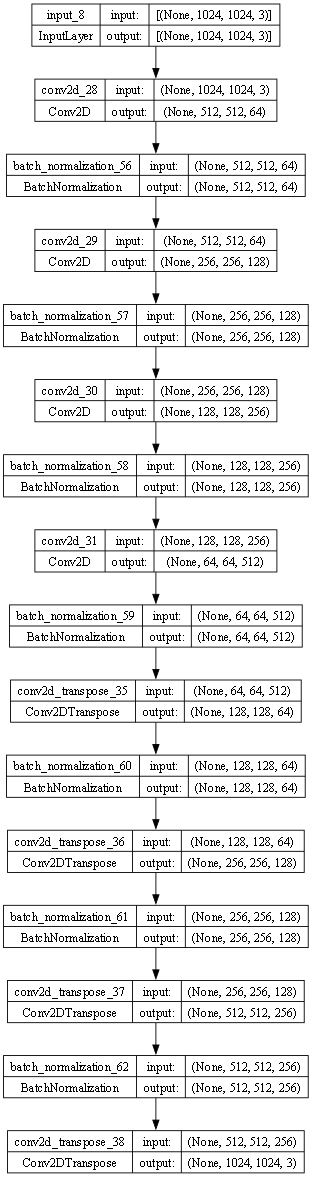

In [ ]:
generator_1024 = Generator_1024()
tf.keras.utils.plot_model(generator_1024, show_shapes=True, dpi=64)

### 2.3.2 Declaración de funciones de pérdida

In [ ]:
LAMBDA = 100

In [ ]:
def generator_loss(loss_object,disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def discriminator_loss(loss_object,disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### 2.3.3 Declarción del discriminador

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[1024, 1024, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[1024, 1024, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 1024, 1024, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 512, 512, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 256, 256, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 128, 128, 256)
  down4 = downsample(512, 4)(down3)  # (batch_size, 64, 64, 512)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  # (batch_size, 66, 66, 512)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 63, 63, 1024)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 65, 65, 1024)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 62, 62, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

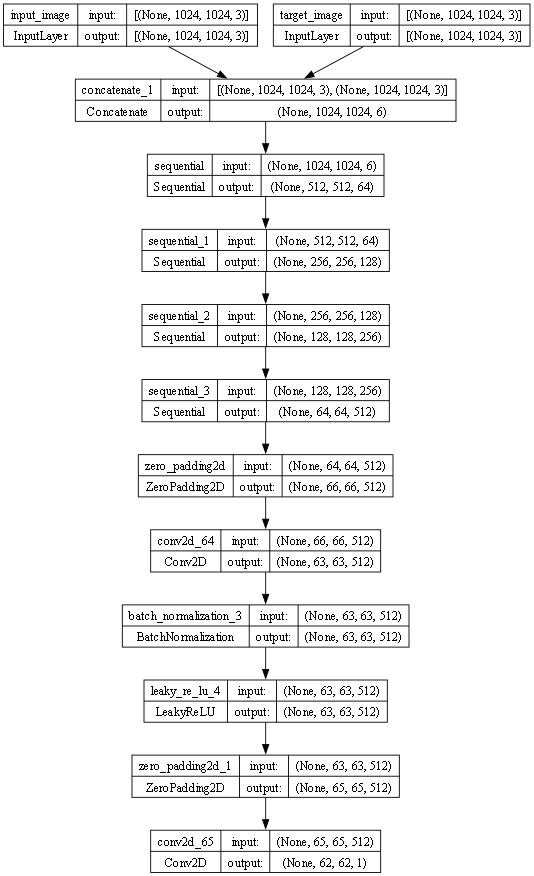

In [ ]:
discriminator_256 = Discriminator()
discriminator_512 = Discriminator()
discriminator_1024 = Discriminator()

tf.keras.utils.plot_model(discriminator_256, show_shapes=True, dpi=64)

### 2.3.4 Declaración de las funciones de entenamiento

In [ ]:
def train_step(generator,discriminator,generator_optimizer,discriminator_optimizer,loss_object,input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    # Uso el método bilinear para reescalar la imagen de input
    bilinear_input_image = tf.image.resize(input_image,size=(1024,1024),method="bilinear")

    disc_real_output = discriminator([bilinear_input_image, target], training=True)
    disc_generated_output = discriminator([target, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(loss_object, disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(loss_object, disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [ ]:
def fit(generator ,discriminator, train_ds,generator_optimizer, discriminator_optimizer , checkpoint, checkpoint_prefix,loss_object, steps):

  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():

    with tf.device('/CPU:0'):
      if (step) % 1000 == 0:
        display.clear_output(wait=True)

        if step != 0:
          print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

        start = time.time()
        print(f"Step: {step//1000}k")

    train_step(generator, discriminator,generator_optimizer, discriminator_optimizer,loss_object,input_image,target)

    # Training step
    with tf.device('/CPU:0'):
      if (step+1) % 10 == 0:
        print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    with tf.device('/CPU:0'):
      if (step + 1) % 5000 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)


### 2.3.5 Entrenamiento

#### 2.3.5.1 Entrenamiento de 256->1024

In [ ]:
generator_optimizer_256 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer_256 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
loss_object_256 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
checkpoint_dir = './Checkpoints/GAN/ckpt_gan_256/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint_256 = tf.train.Checkpoint(generator_optimizer=generator_optimizer_256,
                                 discriminator_optimizer=discriminator_optimizer_256,
                                 generator= generator_256,
                                 discriminator= discriminator_256)

In [ ]:
fit(generator_256,discriminator_256,low_res_train_dataset,generator_optimizer_256,discriminator_optimizer_256,checkpoint_256,checkpoint_prefix,loss_object_256,40000)

Step: 0k
.

#### 2.3.5.2 Entrenamiento de 512->1024

In [ ]:
generator_optimizer_512 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer_512 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
loss_object_512 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
checkpoint_dir = './Checkpoints/GAN/ckpt_gan_512/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint_512 = tf.train.Checkpoint(generator_optimizer=generator_optimizer_512,
                                 discriminator_optimizer=discriminator_optimizer_512,
                                 generator= generator_512,
                                 discriminator= discriminator_512)

In [ ]:
fit(generator_512,discriminator_512,med_res_train_dataset,generator_optimizer_512,discriminator_optimizer_512,checkpoint_512,checkpoint_prefix,loss_object_512,40000)

Step: 0k
....................................................................................................

#### 2.3.5.3 Entrenamiento de 1024->1024

In [ ]:
generator_optimizer_1024 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer_1024 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
loss_object_1024 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
checkpoint_dir = './Checkpoints/GAN/ckpt_gan_1024/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint_1024 = tf.train.Checkpoint(generator_optimizer=generator_optimizer_1024,
                                 discriminator_optimizer=discriminator_optimizer_1024,
                                 generator= generator_1024,
                                 discriminator= discriminator_1024)

In [ ]:
fit(generator_1024,discriminator_1024,high_res_train_dataset,generator_optimizer_1024,discriminator_optimizer_1024,checkpoint_1024,checkpoint_prefix,loss_object_1024,40000)

Step: 0k
....................................................................................................

In [ ]:
generator_256.save("Checkpoints/GAN/generator_256_model")
generator_512.save("Checkpoints/GAN/generator_512_model")
generator_1024.save("Checkpoints/GAN/generator_1024_model")

discriminator_256.save("Checkpoints/GAN/discriminator_256_model")
discriminator_512.save("Checkpoints/GAN/discriminator_512_model")
discriminator_1024.save("Checkpoints/GAN/discriminator_1024_model")

## 2.4 GAN (U-Net o cGAN o pix2pix) <a id="cgan"></a>

 ### 2.4.1 Generadores

#### 2.4.1.1 Generador 256 -> 1024

In [ ]:
def unet_Generator_256():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(1024, 4),  # (batch_size, 1, 1, 1024)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 64)
  ]

  # Última capa de convolucion:
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  #Escalado del modelo:

  x = tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
  x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='SAME')(x)
  x = tf.keras.layers.Lambda(lambda x : tf.nn.depth_to_space(x,2))(x)

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


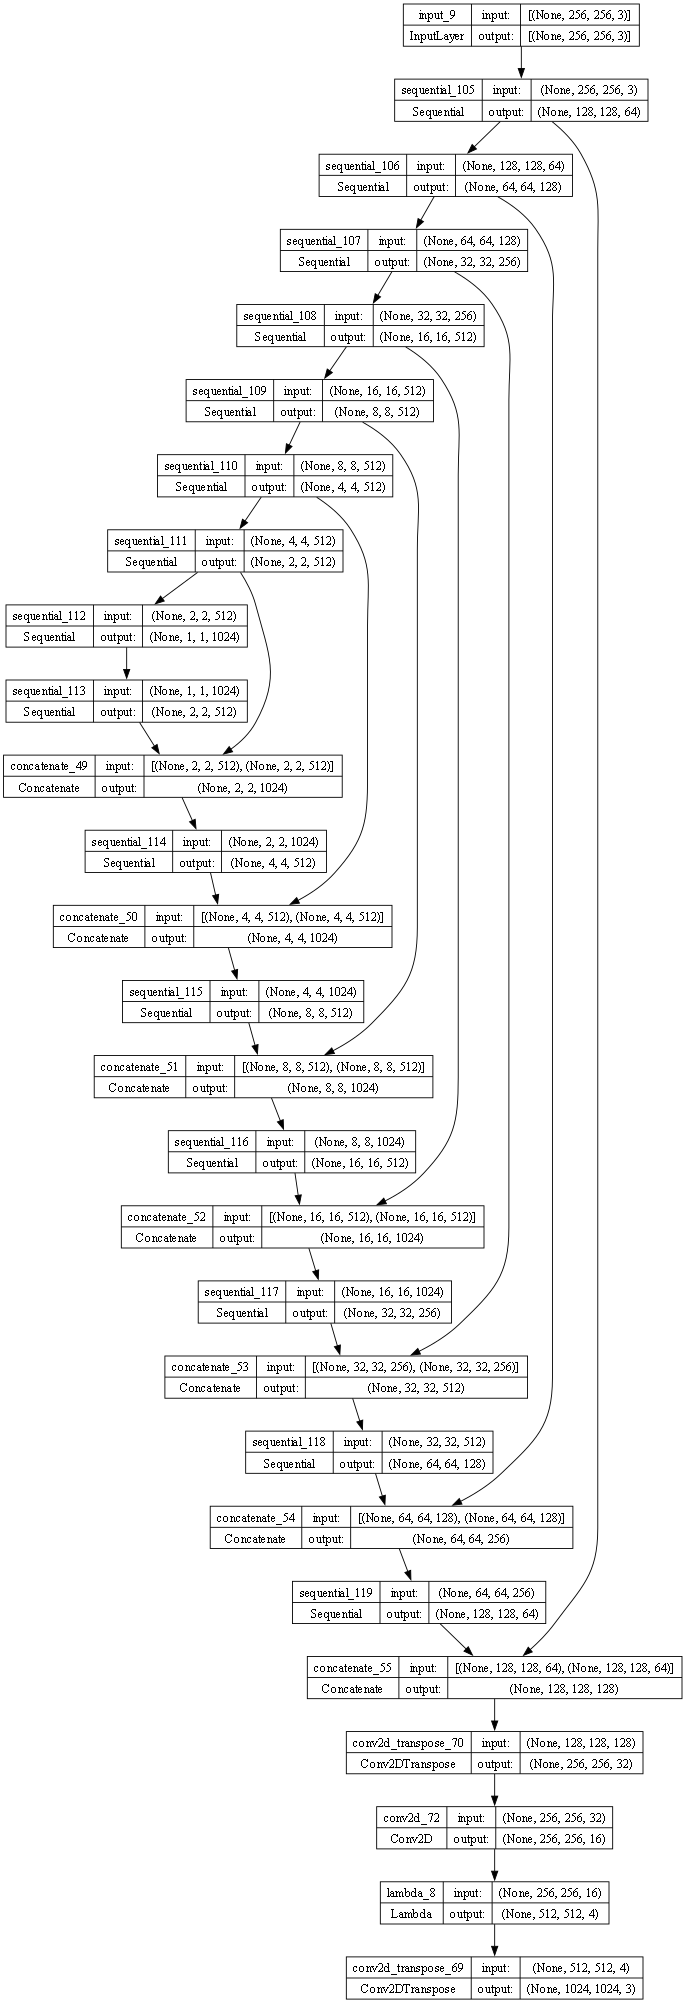

In [ ]:
unet_generator_256 = unet_Generator_256()
tf.keras.utils.plot_model(unet_generator_256, show_shapes=True, dpi=64)

#### 2.4.1.2 Generador 512 -> 1024

In [ ]:
def unet_Generator_512():
  inputs = tf.keras.layers.Input(shape=[512, 512, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 256, 256, 64)
    downsample(128, 4),  # (batch_size, 128, 128, 128)
    downsample(256, 4),  # (batch_size, 64, 64, 256)
    downsample(512, 4),  # (batch_size, 32, 32, 512)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(1024, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(512, 4),  # (batch_size, 32, 32, 1024)
    upsample(256, 4),  # (batch_size, 64, 64, 512)
    upsample(128, 4),  # (batch_size, 128, 128, 256)
    upsample(64, 4),  # (batch_size, 256, 256, 128)
  ]

  # Última capa de convolucion:
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  #Escalado del modelo:
  x = tf.keras.layers.Conv2D(filters= (512 * 4), kernel_size=3, strides=1, padding='SAME')(x)
  x = tf.keras.layers.Lambda(lambda x : tf.nn.depth_to_space(x,2))(x)


  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


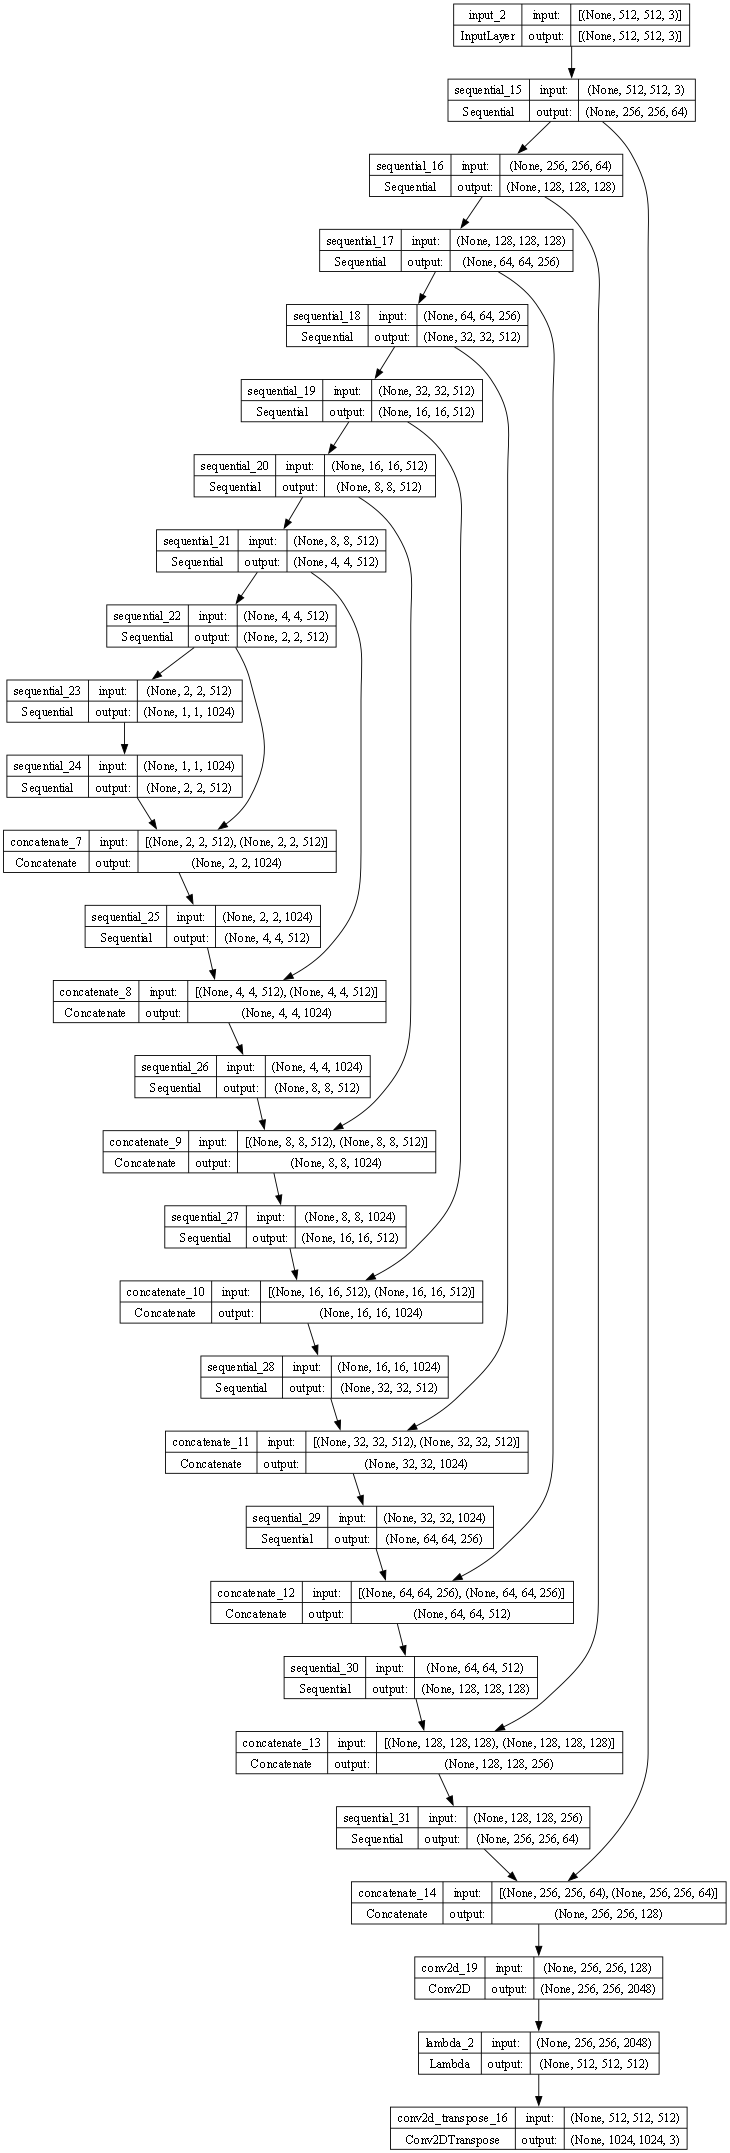

In [ ]:
unet_generator_512 = unet_Generator_512()
tf.keras.utils.plot_model(unet_generator_512, show_shapes=True, dpi=64)

#### 2.4.1.3 Generador 1024->1024

In [ ]:
def unet_Generator_1024():
  inputs = tf.keras.layers.Input(shape=[1024, 1024, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 512, 512, 64)
    downsample(128, 4),  # (batch_size, 256, 256, 128)
    downsample(256, 4),  # (batch_size, 128, 128, 256)
    downsample(512, 4),  # (batch_size, 64, 64, 512)
    downsample(512, 4),  # (batch_size, 32, 32, 512)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(1024, 4),  # (batch_size, 1, 1, 1024)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 1, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 16, 8, 1024)
    upsample(512, 4),  # (batch_size, 32, 32, 1024)
    upsample(512, 4),  # (batch_size, 64, 64, 1024)
    upsample(256, 4),  # (batch_size, 128, 128, 512)
    upsample(128, 4),  # (batch_size, 256, 256, 256)
    upsample(64, 4),  # (batch_size, 512, 512, 128)
  ]

  # Última capa de convolucion:
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


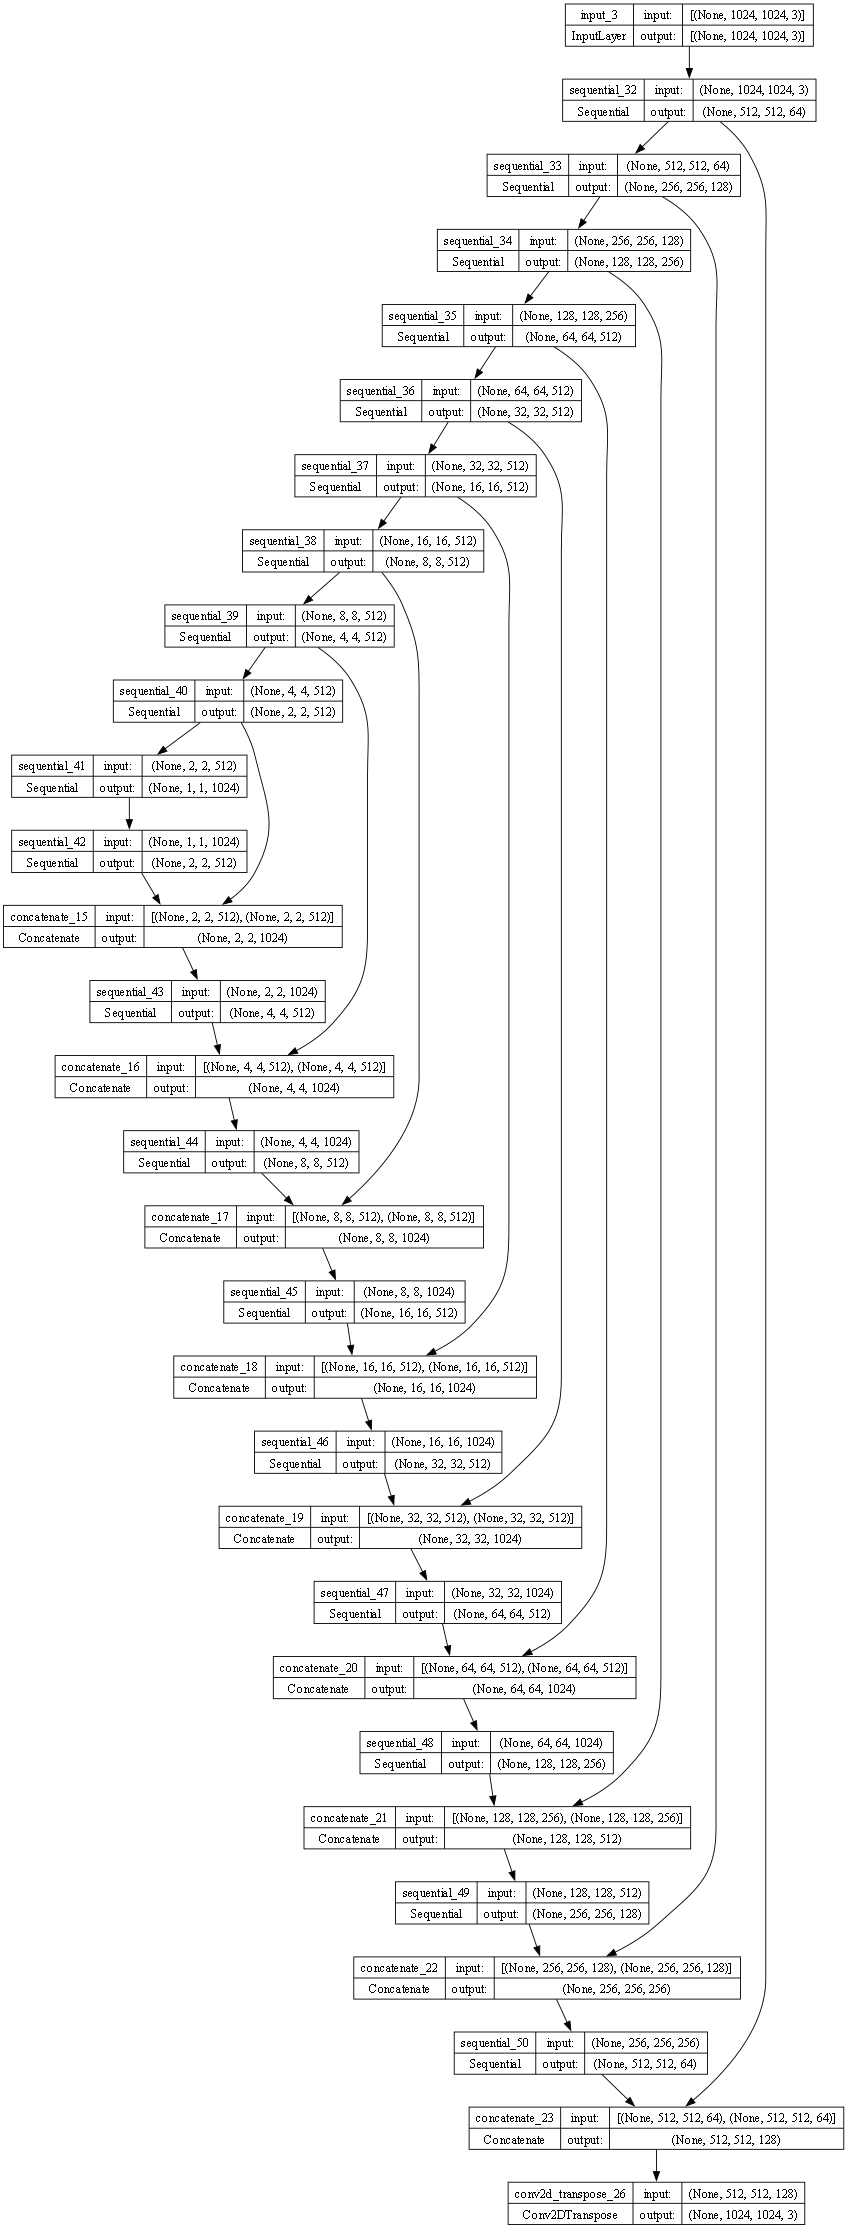

In [ ]:
unet_generator_1024 = unet_Generator_1024()
tf.keras.utils.plot_model(unet_generator_1024, show_shapes=True, dpi=64)

### 2.4.2 Declaración de los discriminadores y entrenamiento

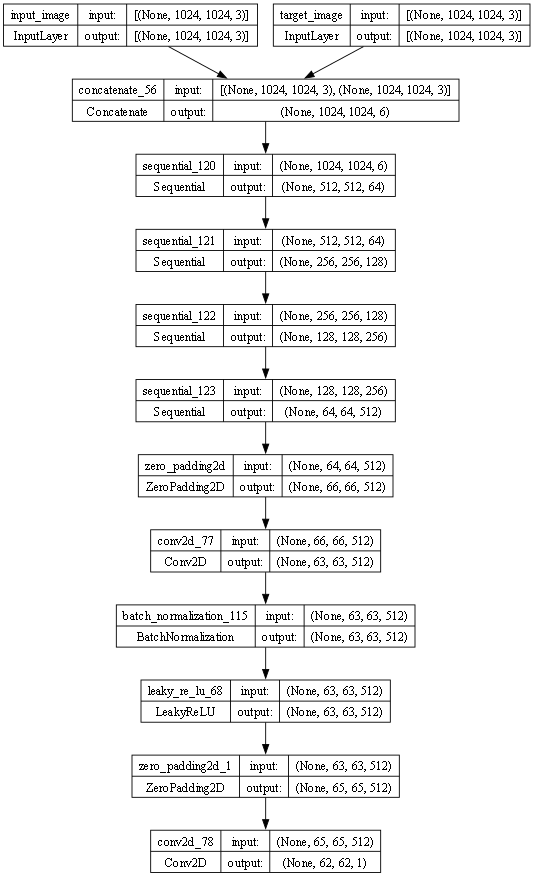

In [ ]:
unet_discriminator_256 = Discriminator()
unet_discriminator_512 = Discriminator()
unet_discriminator_1024 = Discriminator()

tf.keras.utils.plot_model(unet_discriminator_256, show_shapes=True, dpi=64)

#### 2.4.2.1 Entrenamiento de 256->1024

In [ ]:
unet_generator_optimizer_256 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
unet_discriminator_optimizer_256 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
unet_loss_object_256 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
checkpoint_dir = './Checkpoints/unet_GAN/ckpt_gan_256/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
unet_checkpoint_256 = tf.train.Checkpoint(generator_optimizer=unet_generator_optimizer_256,
                                 discriminator_optimizer=unet_discriminator_optimizer_256,
                                 generator=unet_generator_256,
                                 discriminator=unet_discriminator_256)

In [ ]:
fit(unet_generator_256,unet_discriminator_256,low_res_train_dataset,unet_generator_optimizer_256,unet_discriminator_optimizer_256,unet_checkpoint_256,checkpoint_prefix,unet_loss_object_256,50000)

Step: 0k
.

KeyboardInterrupt: 

In [ ]:
def generate_images(model, test_input, tar):
  
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [ ]:
for inp, tar in list(low_res_valid_dataset.as_numpy_iterator())[:5]:
    generate_images(unet_generator_256, inp, tar)

NameError: name 'generate_images' is not defined

#### 2.4.2.2 Entrenamiento de 512->1024

In [ ]:
unet_generator_optimizer_512 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
unet_discriminator_optimizer_512 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
unet_loss_object_512 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
checkpoint_dir = './Checkpoints/unet_GAN/ckpt_gan_512/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
unet_checkpoint_512 = tf.train.Checkpoint(generator_optimizer=unet_generator_optimizer_512,
                                 discriminator_optimizer=unet_discriminator_optimizer_512,
                                 generator=unet_generator_512,
                                 discriminator=unet_discriminator_512)

In [ ]:
fit(unet_generator_512,unet_discriminator_512,med_res_train_dataset,unet_generator_optimizer_512,unet_discriminator_optimizer_512,unet_checkpoint_512,checkpoint_prefix,unet_loss_object_512,1000)

Step: 0k
....................................................................................................

#### 2.4.2.1 Entrenamiento de 1024->1024

In [ ]:
unet_generator_optimizer_1024 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
unet_discriminator_optimizer_1024 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
unet_loss_object_1024 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
checkpoint_dir = './Checkpoints/unet_GAN/ckpt_gan_1024/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
unet_checkpoint_1024 = tf.train.Checkpoint(generator_optimizer=unet_generator_optimizer_1024,
                                 discriminator_optimizer=unet_discriminator_optimizer_1024,
                                 generator=unet_generator_1024,
                                 discriminator=unet_discriminator_1024)

In [ ]:
fit(unet_generator_1024,unet_discriminator_1024,high_res_train_dataset,unet_generator_optimizer_1024,unet_discriminator_optimizer_1024,unet_checkpoint_1024,checkpoint_prefix,unet_loss_object_1024,1000)

Step: 0k
....................................................................................................

In [ ]:
unet_generator_256.save("Checkpoints/unet_GAN/generator_256_model")
unet_generator_512.save("Checkpoints/unet_GAN/generator_512_model")
unet_generator_1024.save("Checkpoints/unet_GAN/generator_1024_model")

unet_discriminator_256.save("Checkpoints/unet_GAN/discriminator_256_model")
unet_discriminator_512.save("Checkpoints/unet_GAN/discriminator_512_model")
unet_discriminator_1024.save("Checkpoints/unet_GAN/discriminator_1024_model")

## 2.5 EDSR_GAN <a id="edsrgan"></a>

### 2.5.1 Creación de la arquitectura EDSR

En la arquitectura EDSR los bloques residuales NO tienen batchnormalization ya que le puede quitar calidad a la imagen:

<img src="./Images/EDSR_structure.png">

In [ ]:

def EDSR(scale, input_shape,B=8, F=256, scale_factor=0.1):

    xinput = tf.keras.layers.Input(shape=input_shape)
    # Primer Conv2d
    xlast = x = tf.keras.layers.Conv2D(filters=F, kernel_size=3, strides=1, padding='SAME')(xinput)
    
    # Bloques residuales:
    def res_block(x):
        x1 = tf.keras.layers.Conv2D(filters= F, kernel_size=3, strides=1, padding='SAME', activation="relu")(x) # Conv2d + relu
        x2 = tf.keras.layers.Conv2D(filters= F, kernel_size=3, strides=1, padding='SAME')(x1) # Conv2d

        x2 = x2 * scale_factor # Mult
        output = tf.keras.layers.Add()([x2, x]) # Add
        return output
    
    # B ResBlocks
    for i in range(B):
        x = res_block(x)

    # Último Conv2d
    x = tf.keras.layers.Conv2D(filters=F, kernel_size=3, strides=1, padding='SAME')(x)
    # Último Add
    x = tf.keras.layers.Add()([x,xlast])

    # Upsample
    if scale == 2: # x2 512
        x = tf.keras.layers.Conv2D(filters= (16), kernel_size=3, strides=1, padding='SAME')(x)
        x = tf.keras.layers.Lambda(lambda x : tf.nn.depth_to_space(x,2))(x)
    elif scale == 4: # x4 256

        x = tf.keras.layers.Conv2D(filters= (32), kernel_size=3, strides=1, padding='SAME')(x)
        x = tf.keras.layers.Lambda(lambda x : tf.nn.depth_to_space(x,2))(x)

        x = tf.keras.layers.Conv2D(filters= (16), kernel_size=3, strides=1, padding='SAME')(x)
        x = tf.keras.layers.Lambda(lambda x : tf.nn.depth_to_space(x,2))(x)

    out = tf.keras.layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='SAME')(x)

    return tf.keras.models.Model(xinput, out)


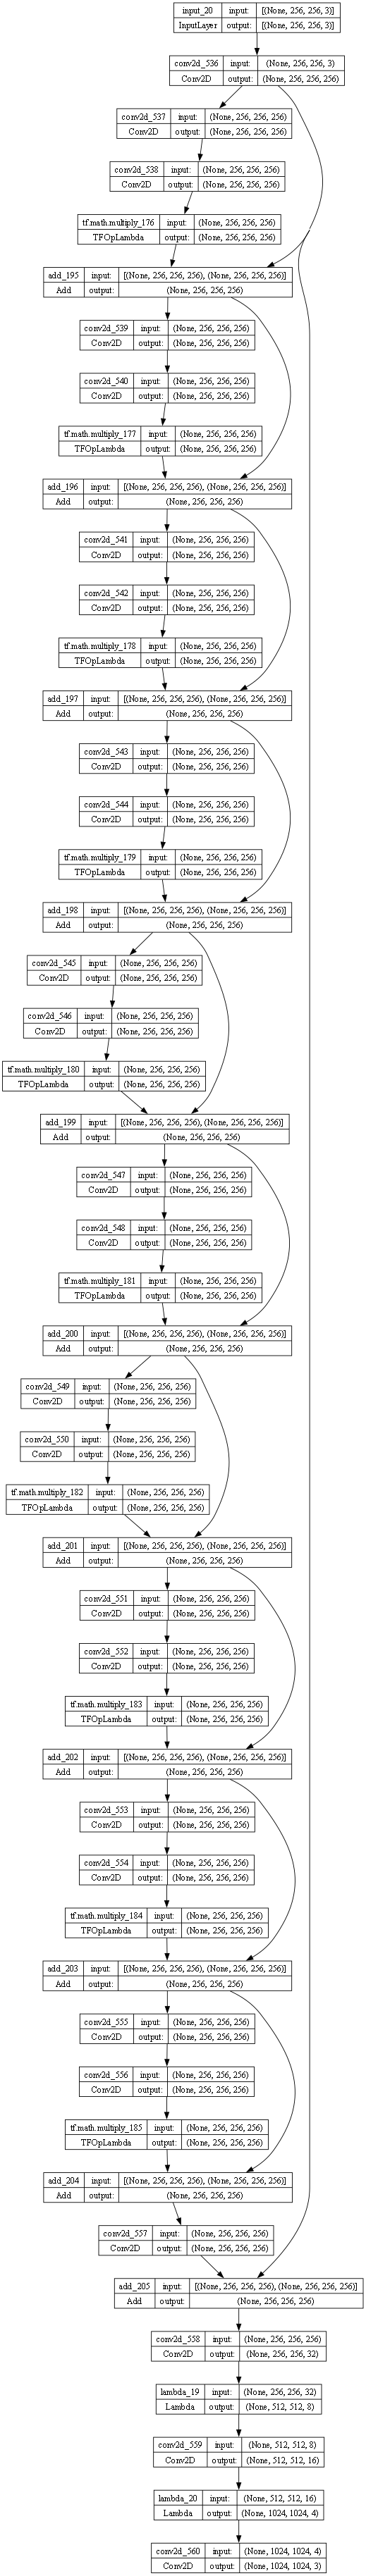

In [ ]:
edsr_generator_256 = EDSR(4,(256,256,3))
tf.keras.utils.plot_model(edsr_generator_256, show_shapes=True, dpi=64)

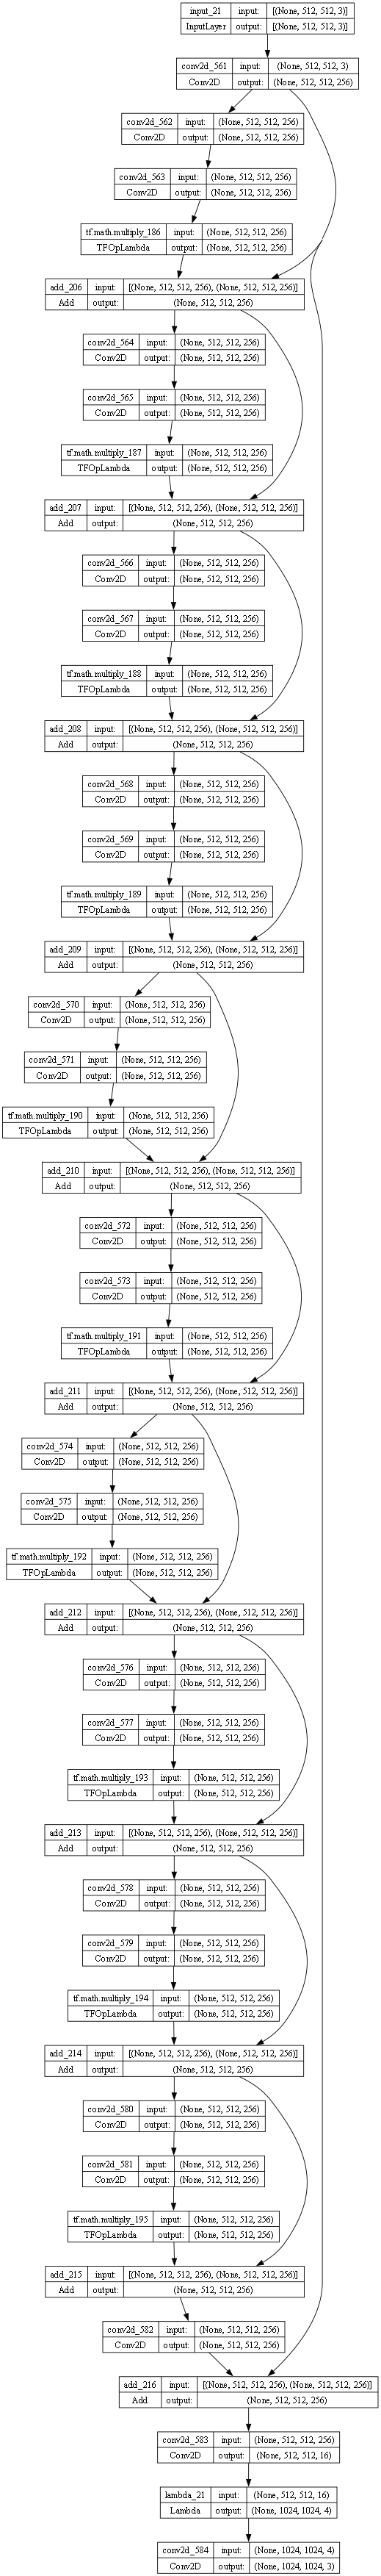

In [ ]:
edsr_generator_512 = EDSR(2,(512,512,3))
tf.keras.utils.plot_model(edsr_generator_512, show_shapes=True, dpi=64)

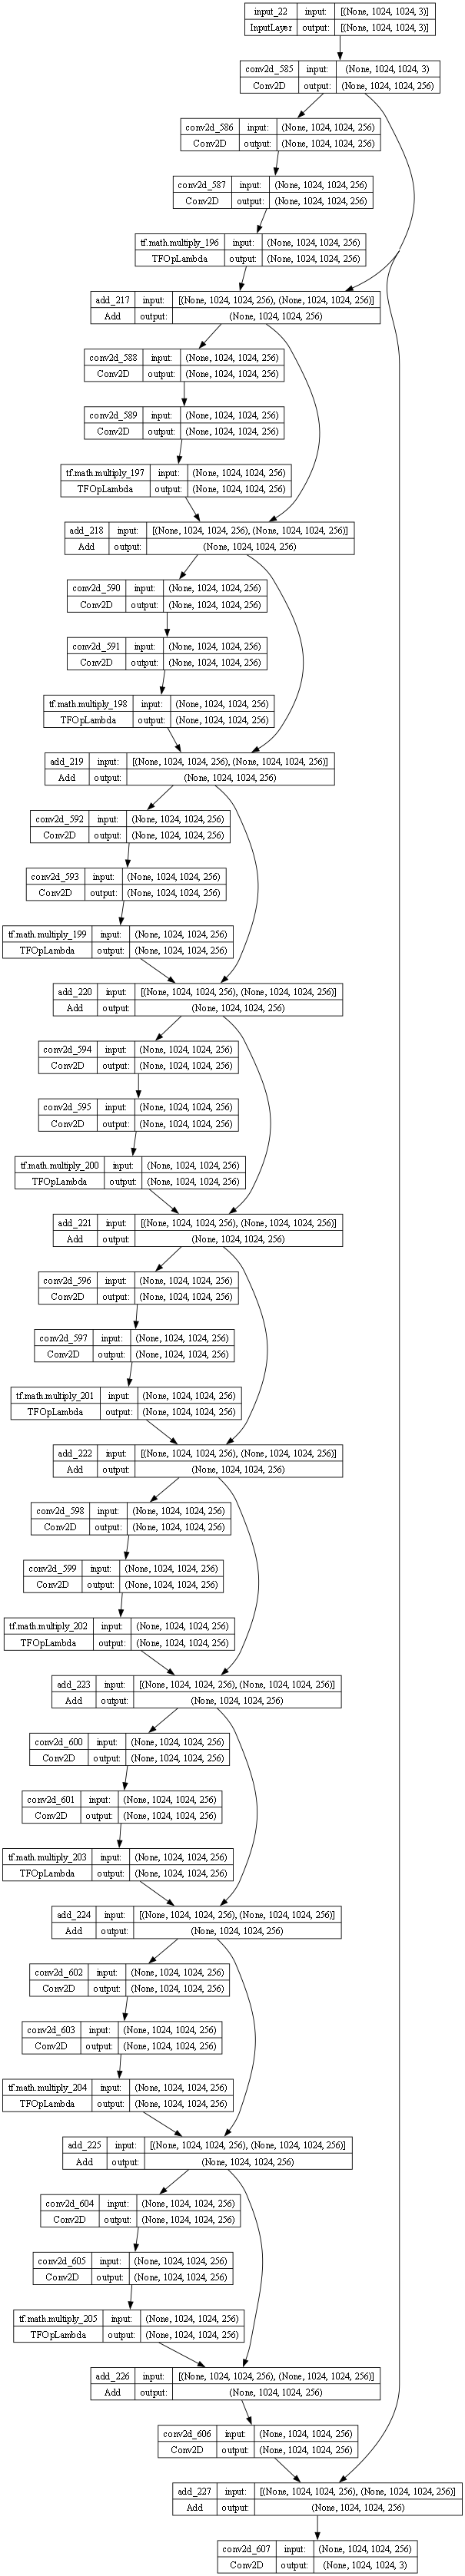

In [ ]:
edsr_generator_1024 = EDSR(0,(1024,1024,3))
tf.keras.utils.plot_model(edsr_generator_1024, show_shapes=True, dpi=64)

### 2.5.2 Declaración de los discriminadores y entrenamiento

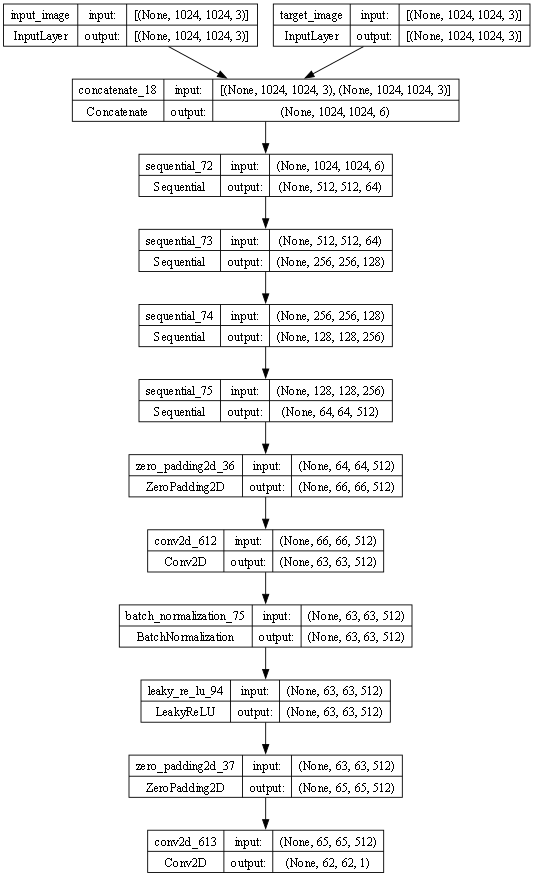

In [ ]:
edsr_discriminator_256 = Discriminator()
edsr_discriminator_512 = Discriminator()
edsr_discriminator_1024 = Discriminator()

tf.keras.utils.plot_model(edsr_discriminator_256, show_shapes=True, dpi=64)

#### 2.5.2.1 Entrenamiento 256->1024

In [ ]:
edsr_generator_optimizer_256 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
edsr_discriminator_optimizer_256 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
edsr_loss_object_256 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
checkpoint_dir = './Checkpoints/edsr_GAN/ckpt_gan_256/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
edsr_checkpoint_256 = tf.train.Checkpoint(generator_optimizer=edsr_generator_optimizer_256,
                                 discriminator_optimizer=edsr_discriminator_optimizer_256,
                                 generator=edsr_generator_256,
                                 discriminator=edsr_discriminator_256)

In [ ]:
fit(edsr_generator_256,edsr_discriminator_256,low_res_train_dataset,edsr_generator_optimizer_256,edsr_discriminator_optimizer_256,edsr_checkpoint_256,checkpoint_prefix,edsr_loss_object_256,40000)

Step: 0k


#### 2.5.2.2 Entrenamiento 512->1024

In [ ]:
edsr_generator_optimizer_512 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
edsr_discriminator_optimizer_512 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
edsr_loss_object_512 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
checkpoint_dir = './Checkpoints/edsr_GAN/ckpt_gan_512/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
edsr_checkpoint_512 = tf.train.Checkpoint(generator_optimizer=edsr_generator_optimizer_512,
                                 discriminator_optimizer=edsr_discriminator_optimizer_512,
                                 generator=edsr_generator_512,
                                 discriminator=edsr_discriminator_512)

In [ ]:
fit(edsr_generator_512,edsr_discriminator_512,med_res_train_dataset,edsr_generator_optimizer_512,edsr_discriminator_optimizer_512,edsr_checkpoint_512,checkpoint_prefix,edsr_loss_object_512,40000)

#### 2.5.2.3 Entrenamiento 512->1024

In [ ]:
edsr_generator_optimizer_1024 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
edsr_discriminator_optimizer_1024 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
edsr_loss_object_1024 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
checkpoint_dir = './Checkpoints/edsr_GAN/ckpt_gan_512/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
edsr_checkpoint_1024 = tf.train.Checkpoint(generator_optimizer=edsr_generator_optimizer_1024,
                                 discriminator_optimizer=edsr_discriminator_optimizer_1024,
                                 generator=edsr_generator_1024,
                                 discriminator=edsr_discriminator_1024)

In [ ]:
fit(edsr_generator_1024,edsr_discriminator_1024,high_res_train_dataset,edsr_generator_optimizer_1024,edsr_discriminator_optimizer_1024,edsr_checkpoint_1024,checkpoint_prefix,edsr_loss_object_1024,40000)

In [ ]:
edsr_generator_256.save("Checkpoints/edsr_GAN/generator_256_model")
edsr_generator_512.save("Checkpoints/edsr_GAN/generator_512_model")
edsr_generator_1024.save("Checkpoints/edsr_GAN/generator_1024_model")

edsr_discriminator_256.save("Checkpoints/edsr_GAN/discriminator_256_model")
edsr_discriminator_512.save("Checkpoints/edsr_GAN/discriminator_512_model")
edsr_discriminator_1024.save("Checkpoints/edsr_GAN/discriminator_1024_model")

# 3. Comparación de modelos <a id="comparacionmodelos"></a>

# 3.1 Métricas individuales <a id="mi"></a>

# 3.2 Tablas comparativas de métricas <a id="tcm"></a>

# 3.3 Comparativa de imágenes <a id="ci"></a>